In [2]:
import pystan
import pylab as plt
import seaborn as sns
import numpy as np
%matplotlib inline
import pandas as pd
import seaborn as sns

# MindLab Model for shelving
There are three variables that could effect whether an item is selected, `product_index`, `product` and `price`. We want to be able to marginalise out product and price to see effect of shelf position (`product_index`). As there is a binary input from the user, we will use the bernoulli probability distribution as our likelihood function. The bernoulli distribution is a special case of the binomial distribution i.e. when n=1.


$$y_j\sim\mbox{bernoulli}\left( \mbox{logit}^{-1}(f(\alpha_{i},\beta_i,c_{\gamma}))\right),\mbox{ for } j=1,\dots, J.$$

* $y_{ij}$ is the response for person $j$ to a particular product ($m_{\alpha}$) at a particular price ($\beta_{i}$)   and location on shelf ($c_{i}$) i.e. `fit`=1 or `does not fit`=0
* $m_{\alpha} $ is product (discrete)
* $\beta_i$ is price (continuous)
* $c_{\gamma}$ is position (discrete)

The key is coming up with the function ($f$)

For our first model, we will assume a linear relationship:
$$m_{\alpha}*\beta_{i}+c_{\gamma}$$
where:
* $m$ is slope, telling us how much price affects selection
* $c$ is intercept, telling us how much product position changes selection

Note, this model is treating all products the same

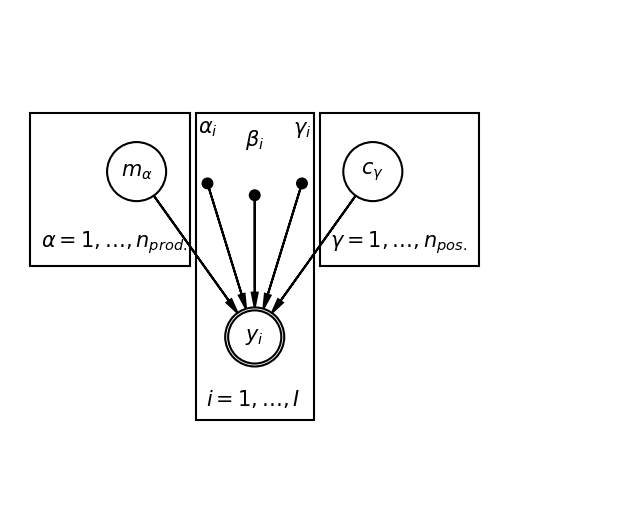

In [33]:
import daft

pgm = daft.PGM(shape=(5,4),observed_style="inner",dpi=150)

pgm.add_node('m',r'$m_{\alpha}$',1,2.7)
pgm.add_node('beta',r'$\beta_i$',2,2.5,fixed=True)
pgm.add_node('c',r'$c_{\gamma}$',3,2.7)
pgm.add_node('y',r'$y_i$',2,1.3,observed=True)
pgm.add_node('alpha',r'$\alpha_i$',1.6,2.6,fixed=True)
pgm.add_node('gamma',r'$\gamma_i$',2.4,2.6,fixed=True)



pgm.add_edge('m','y')
pgm.add_edge('beta','y')
pgm.add_edge('c','y')
pgm.add_edge('gamma','y')
pgm.add_edge('alpha','y')


pgm.add_plate([1.5, 0.7, 1, 2.5], label=r"$i = 1, \ldots, I$", shift=-0.1)
pgm.add_plate([0.1, 2, 1.35, 1.2], label=r"$\alpha = 1, \ldots, n_{prod.}$", shift=-0.1)
pgm.add_plate([2.55, 2, 1.35, 1.2], label=r"$\gamma = 1, \ldots, n_{pos.}$", shift=-0.1)



# Render and save.
pgm.render()
pgm.show()

## Build the model

In [18]:
model="""
data {
  int<lower=1> K;              // number of product places
  int<lower=1> N;              // number of observations
  vector[N] price;  //product price for observation n
  int<lower=1,upper=K> kk[N];  // product place for observation n
  int<lower=0,upper=1> y[N];   // selected or not for observation n
  int<lower=0> nprice; //number of price points
  vector[nprice] price_pred; //price points for predictions
}

parameters {
  vector[K] c;              // effect of place for k
  real m; // slope;
}

model {
  m ~ std_normal();
  c ~ normal(0, 1);
  if (N > 1){
  y ~ bernoulli_logit(m*price + c[kk]);
  }
}

generated quantities {
vector[N] y_rep;
matrix[nprice,K] pred_matrix;
matrix[nprice,K] pred_matrix_select;

for (i in 1:nprice){
for (j in 1:K){
pred_matrix[i,j]=m*price_pred[i] + c[j];
pred_matrix_select[i,j]=bernoulli_logit_rng(pred_matrix[i,j]);
}
}

if (N > 1){
for (i in 1:N){
y_rep[i] = bernoulli_logit_rng(m*price[i] + c[kk[i]]);
}
}
}
"""

In [19]:
sm=pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7ce66c5d545192ffc244e3068202c7b4 NOW.


In [50]:
data={
    'K':5,
    'N':1,
    'price':[0],
    'kk':[1],
    'y':[1],
    'nprice':10,
    'price_pred':np.arange(-5,5,1.0)
}

In [51]:
fit=sm.sampling(data=data,chains=1,iter=500)

In [52]:
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_7ce66c5d545192ffc244e3068202c7b4.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

                           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c[1]                       0.02    0.06   1.14  -2.15  -0.55    0.1   0.61   2.23    377    1.0
c[2]                      -0.07    0.05   1.01  -2.12   -0.8  -0.09   0.69   1.74    403    1.0
c[3]                       0.09    0.07   0.99  -1.52   -0.6   0.07   0.77   2.01    228    1.0
c[4]                       0.06    0.05   1.02  -1.95  -0.62   0.03   0.81   1.86    359    1.0
c[5]                    -4.7e-3    0.06   1.01  -1.85  -0.77  -0.07   0.69   1.96    281    1.0
m                         -0.03    0.06   1.02  -1.94  -0.79-2.3e-3   0.71   1.83    317    1.0
y_rep[1]                    nan     nan    nan    nan    nan    nan    nan    nan    nan    nan
pred_ma

Text(0.5, 0, 'Slope')

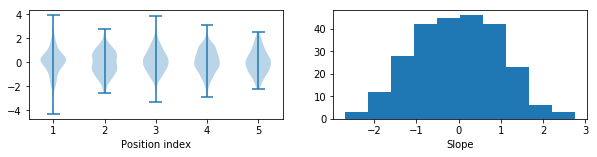

In [53]:
plt.figure(figsize=(10,2))
plt.subplot(1,2,1)
plt.violinplot(fit['c']);
plt.xlabel('Position index')
plt.subplot(1,2,2)
plt.hist(fit['m']);
plt.xlabel('Slope')

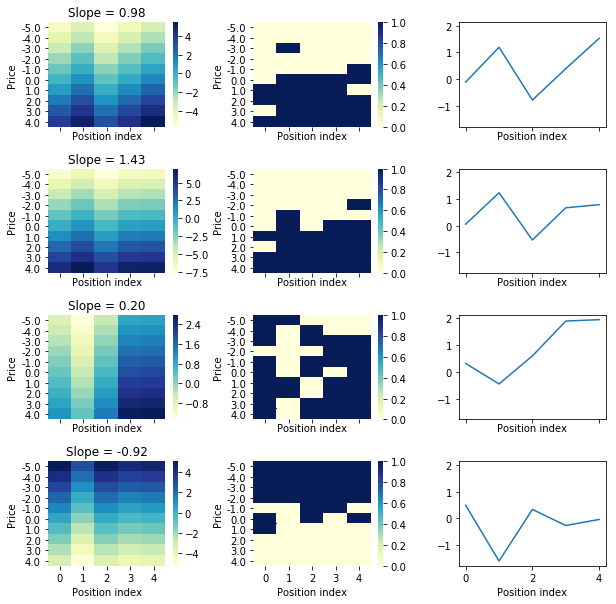

In [79]:
s=[0,1,2,10]
fig, ax = plt.subplots(len(s), 3, sharex='col', sharey='col',figsize=(10,10))

for i in range(0,len(s)):
    sns.heatmap(fit['pred_matrix'][s[i],:,:],yticklabels=fit.data['price_pred'],cmap="YlGnBu",ax=ax[i,0],)
    ax[i,0].set_xlabel('Position index')
    ax[i,0].set_ylabel('Price')
    ax[i,0].set_title(r'Slope = {:.2f}'.format(fit['m'][s[i]],fit['c'][s[i]]))
    sns.heatmap(fit['pred_matrix_select'][s[i],:,:],yticklabels=fit.data['price_pred'],cmap="YlGnBu",ax=ax[i,1])
    ax[i,1].set_xlabel('Position index')
    ax[i,1].set_ylabel('Price')
    ax[i,2].plot(fit['c'][s[i]])
    ax[i,2].set_xlabel('Position index')
fig.subplots_adjust(hspace=0.4, wspace=0.4)


## Fit prior samples

In [112]:
def zscore(posterior, truth):
    return np.abs((np.mean(posterior)-truth)/np.std(posterior))
def shrinkage(posterior,prior):
    return 1-(np.var(posterior)/np.var(prior))

In [80]:
def get_indicators(N, M, prob_std=0.5):
    ind = np.random.binomial(1, prob_std, (N, M))
    return ind>0

In [124]:
zscore_prior_pred_c=np.empty((fit.data['K'],10))
zscore_prior_pred_m=np.empty((1,10))
shrinkage_prior_pred_c=np.empty((fit.data['K'],10))
shrinkage_prior_pred_m=np.empty((1,10))


for s in range(0,10):
    data_prior={
        'K':fit.data['K'],
        'N':fit['pred_matrix'][s,:,:].flatten().size,
        'price':np.repeat(np.arange(-5,5,1.0),5),
        'kk':np.tile(np.arange(1,6,1),10),
        'y':fit['pred_matrix_select'][s,:,:].flatten().astype(int),
        'nprice':10,
        'price_pred':np.arange(-5,5,1.0)
    }
    fit_prior=sm.sampling(data=data_prior)
    zscore_prior_pred_c[:,s]=zscore(fit_prior['c'],fit['c'][s,:])
    for i in range(0,fit.data['K']):
        shrinkage_prior_pred_c[i,s]=shrinkage(fit_prior['c'][:,i],fit['c'][:,i])
    zscore_prior_pred_m[0,s]=zscore(fit_prior['m'],fit['m'][s])
    shrinkage_prior_pred_m[0,s]=shrinkage(fit_prior['m'][:],fit['m'][:])

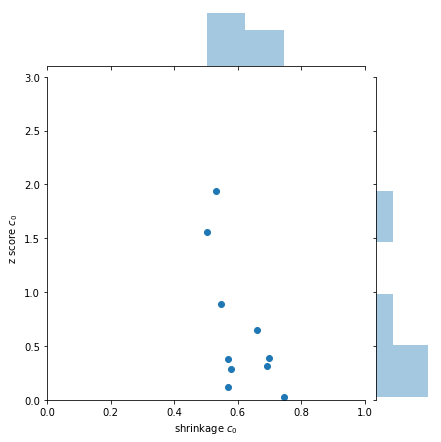

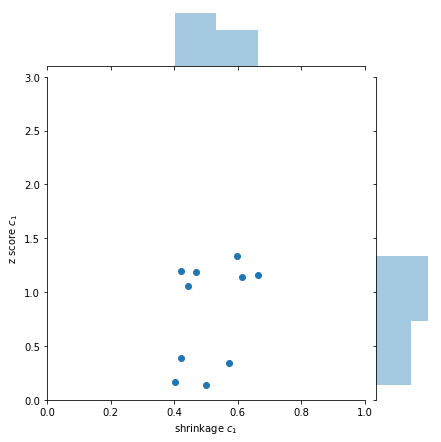

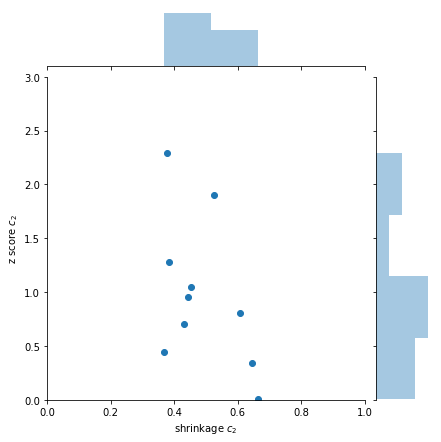

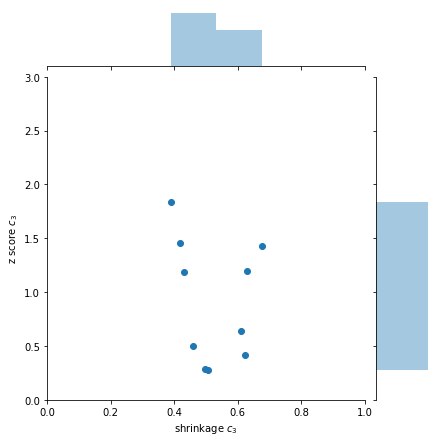

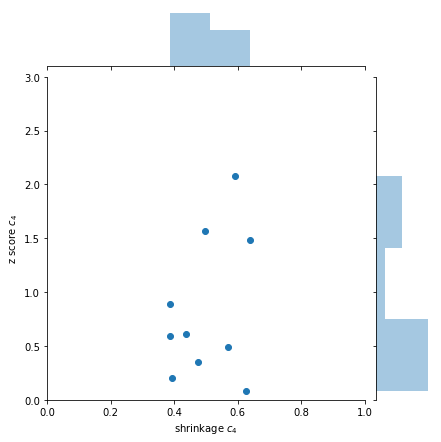

In [141]:
for i in range(0,zscore_prior_pred_c.shape[0]):
    g=sns.jointplot(shrinkage_prior_pred_c[i,:],zscore_prior_pred_c[i,:],xlim=[0,1],ylim=[0,3])
    g.set_axis_labels(r'shrinkage $c_{:4.0f}$'.format(i),r'z score $c_{:4.0f}$'.format(i))

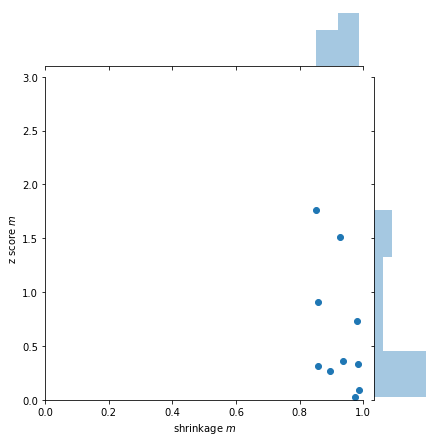

In [143]:
g=sns.jointplot(shrinkage_prior_pred_m[0,:],zscore_prior_pred_m[0,:],xlim=[0,1],ylim=[0,3])
g.set_axis_labels(r'shrinkage $m$'.format(i),r'z score $m$'.format(i))

# Fit model to data
At the moment the model is built for one person and one product. We could assume everyone acts the same as a first pass and fit for every object.

In [144]:
data=pd.read_csv('../../../data/raw/priced_shelves_data.csv')
data['id.session_int']=data.groupby('id.session').grouper.group_info[0]+1
data['selected_int']=data.groupby('selected').grouper.group_info[0]

In [149]:
data[data['product']==data['product'].unique()[0]]

,id.session,trial_index,shelf_index,product_index,product,price,pre_discounted,selected,latency,id.session_int,selected_int
0,5d43fd1f440799001a4b5cbd,0,0,0,smirnoff,12,NaN,False,NaN,1,0
14,5d43fd1f440799001a4b5cbd,1,0,0,smirnoff,15,NaN,False,NaN,1,0
28,5d43fd1f440799001a4b5cbd,2,0,0,smirnoff,14,NaN,False,NaN,1,0
42,5d43fd1f440799001a4b5cbd,3,0,0,smirnoff,9,NaN,False,NaN,1,0
56,5d43fd1f440799001a4b5cbd,4,0,0,smirnoff,16,NaN,False,NaN,1,0
70,5d43fd1f440799001a4b5cbd,5,0,0,smirnoff,11,NaN,False,NaN,1,0
84,5d43fd1f440799001a4b5cbd,6,0,0,smirnoff,12,NaN,False,NaN,1,0
98,5d43fd1f440799001a4b5cbd,7,0,0,smirnoff,14,NaN,False,NaN,1,0
112,5d43fd1f440799001a4b5cbd,8,0,0,smirnoff,15,NaN,False,NaN,1,0
126,5d43fd1f440799001a4b5cbd,9,0,0,smirnoff,13,NaN,False,NaN,1,0


### smirnoff

In [160]:
data_infer={
    'K':data['product_index'].unique().size,
    'N':len(data[data['product']==data['product'].unique()[0]]),
    'price':data[data['product']==data['product'].unique()[0]]['price'],
    'kk':data[data['product']==data['product'].unique()[0]]['product_index'].values+1,
    'y':data[data['product']==data['product'].unique()[0]]['selected_int'],
    'nprice':9,
    'price_pred':np.arange(8,17,1.0)
}

In [161]:
fit_infer=sm.sampling(data=data_infer)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [163]:
fit_infer


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_7ce66c5d545192ffc244e3068202c7b4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c[1]        0.96  3.7e-3   0.16   0.64   0.85   0.96   1.07   1.27   1967    1.0
c[2]     -1.2e-3    0.01   0.99   -2.0  -0.66 4.4e-3   0.68    2.0   4680    1.0
c[3]        0.02    0.01   0.98  -1.94  -0.65   0.03   0.68   1.92   4641    1.0
c[4]      6.4e-3    0.01   0.99  -2.01  -0.68   0.02   0.68   1.91   4831    1.0
c[5]      9.4e-3    0.02   1.02  -1.98   -0.7-4.7e-3   0.69   2.05   4411    1.0
c[6]      2.6e-3    0.01   0.98  -1.91  -0.65   0.03   0.67   1.86   5340    1.0
c[7]        0.03    0.01   0.96  -1.84  -0.63   0.02   0.68   1.89   4390    1.0
c[8]     -4.7e-3    0.02    1.0  -1.97  -0.67-7.5e-3    0.7   1.96   4102    1.0
c[9]        1.02  3.8e-3   0.16   0.71   0

[]

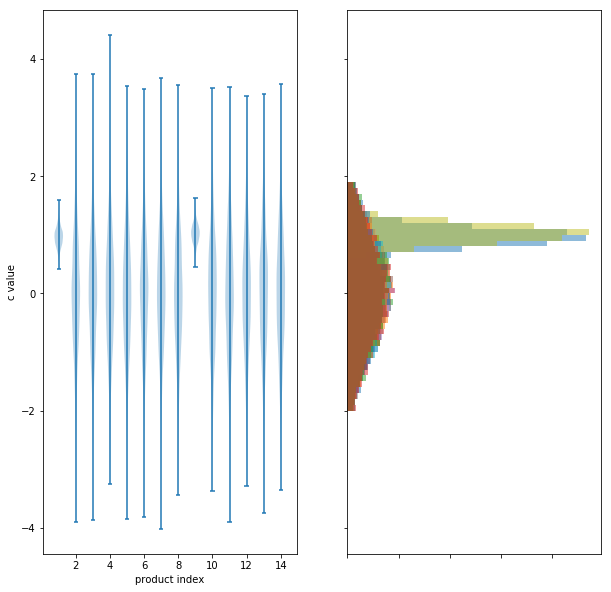

In [182]:
fig, ax = plt.subplots(1, 2, sharey='row',figsize=(10,10))

ax[0].violinplot(fit_infer['c']);
for i in range(0,fit_infer.data['K']):
    ax[1].hist(fit_infer['c'][:,i],orientation='horizontal',alpha=0.5,bins=np.arange(-2,2,0.1));
ax[0].set_ylabel('c value')
ax[0].set_xlabel('product index')
ax[1].set_xticklabels([])

### ciroc

In [184]:
data_infer={
    'K':data['product_index'].unique().size,
    'N':len(data[data['product']==data['product'].unique()[1]]),
    'price':data[data['product']==data['product'].unique()[1]]['price'],
    'kk':data[data['product']==data['product'].unique()[1]]['product_index'].values+1,
    'y':data[data['product']==data['product'].unique()[1]]['selected_int'],
    'nprice':9,
    'price_pred':np.arange(8,17,1.0)
}

In [185]:
fit_infer=sm.sampling(data=data_infer)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


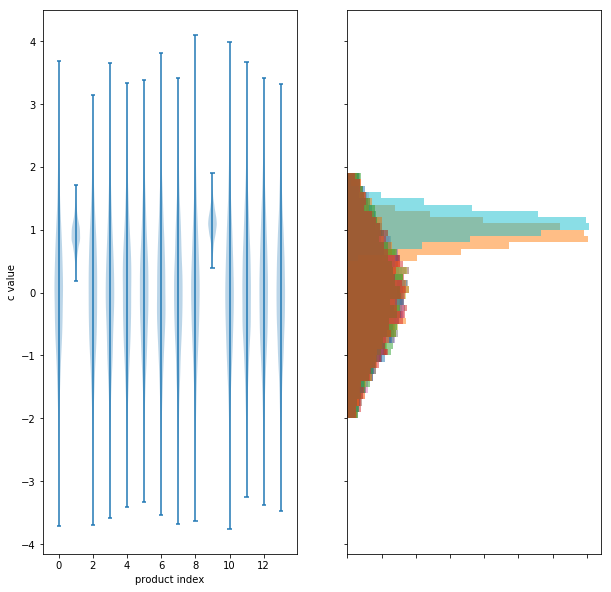

In [207]:
fig, ax = plt.subplots(1, 2, sharey='row',figsize=(10,10))

ax[0].violinplot(fit_infer['c'],positions=data['product_index'].unique());
for i in range(0,fit_infer.data['K']):
    ax[1].hist(fit_infer['c'][:,i],orientation='horizontal',alpha=0.5,bins=np.arange(-2,2,0.1));
ax[0].set_ylabel('c value')
ax[0].set_xlabel('product index')
ax[1].set_xticklabels([]);

The plots above show the posterior on $c$ the intercept, or bias coming from product position. The left plot is a violin plot and the right plot shows the same same distributions, but overlapping so it is easier to compare overlap. 

Product index 1 and 9 are the only positions used for `ciroc`. The other positions have posteriors that are dominated by our prior. Position 9 has a preference over position 1.

Text(0, 0.5, '$c_{9}$')

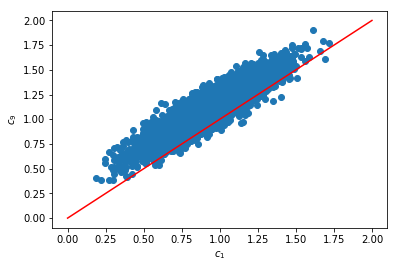

In [206]:
plt.scatter(fit_infer['c'][:,1],fit_infer['c'][:,9])
plt.plot(np.arange(0,3),np.arange(0,3),'r')
plt.xlabel(r'$c_{1}$')
plt.ylabel(r'$c_{9}$')

This plot investigates that preference a bit further. We can plot the samples from the posterior distributions for $c_1$ and $c_9$ against each other. The red line is the one to one line. For points above the line, $c_9$ is greater than $c_1$, for points below, $c_1$ is greater than $c_9$. By counting the number of points above the line, we can work out $P(c_9 > c_1)$. Interestingly, the number of points seems less than we might expect by looking at the histogram. This is due to the correlation between the two slopes, i.e. as one goes up, so does the other.

In [214]:
ind=fit_infer['c'][:,1]<fit_infer['c'][:,9]
print(r'P(c_9 > c_1) = {:6.4f}'.format(ind.sum()/fit_infer['c'].shape[0]))

P(c_9 > c_1) = 0.9597


#### Posterior Predictive checks
The only data we have are the selections. We could look at the number of selections as a function of price, and compare to our replicated data,

In [297]:
counts_data=np.empty((np.unique(fit_infer.data['kk']).size,np.unique(fit_infer.data['price'].values).size))
for i,pi in enumerate(np.unique(fit_infer.data['kk'])):
    for j,pri in enumerate(np.unique(fit_infer.data['price'].values)):
        ind=(fit_infer.data['kk']==pi) & (fit_infer.data['price'].values == pri)
        ind2=fit_infer.data['y'][ind].values==1
        counts_data[i,j]=ind2.sum()/ind.sum()

In [299]:
counts_rep=np.empty((fit_infer['y_rep'].shape[0],np.unique(fit_infer.data['kk']).size,np.unique(fit_infer.data['price'].values).size))


for i,pi in enumerate(np.unique(fit_infer.data['kk'])):
    for j,pri in enumerate(np.unique(fit_infer.data['price'].values)):
        ind=(fit_infer.data['kk']==pi) & (fit_infer.data['price'].values == pri)
        ind2=fit_infer['y_rep'][:,ind]>0
        counts_rep[:,i,j]=ind2.sum(axis=1)/ind.sum()
    

Text(0, 0.5, 'No. of selected/No. of total')

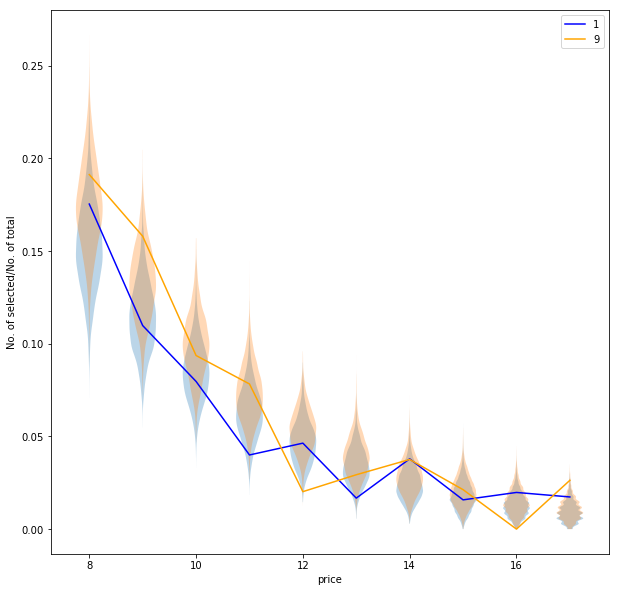

In [318]:
color=['blue','orange']
plt.figure(figsize=(10,10))
plt.violinplot(counts_rep[:,0,:],showextrema=False,positions=np.unique(fit_infer.data['price'].values));
plt.violinplot(counts_rep[:,1,:],showextrema=False,positions=np.unique(fit_infer.data['price'].values));
for i,pi in enumerate(np.unique(fit_infer.data['kk'])):
    plt.plot(np.unique(fit_infer.data['price'].values),counts_data[i,:],color=color[i],label=pi-1)
plt.legend()
plt.xlabel('price')
plt.ylabel('No. of selected/No. of total')

The plot above shows the fraction selected over total for each price and position. The lines are from the data, the violin plots are the distributions for our replicated data. The replicated data distribution shows the uncertianty our model has in the fraction. If our model is doing a good job, the lines should roughly fall within the distributions. They do.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  if sys.path[0] == '':


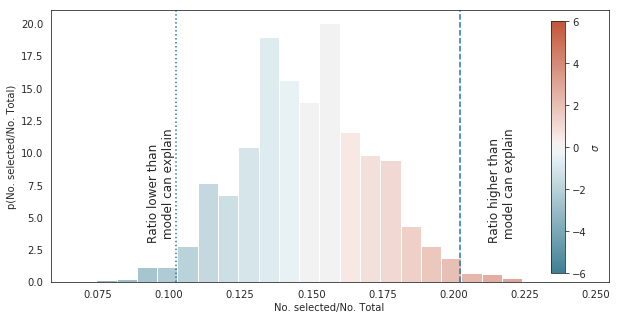

In [324]:
import seaborn as sns
import matplotlib as mpl
sns.set_style("white")

fig=plt.figure(figsize=(10,5))


# This is  the colormap I'd like to use.
cm = sns.diverging_palette(220, 20, as_cmap=True)

# Get the histogramp
Y,X = np.histogram(counts_rep[:,0,0], 25, normed=1)
#C = [cm(((x-X.min())/x_span)) for x in X]
C = [cm(((((x-np.mean(counts_rep[:,0,0]))/np.std(counts_rep[:,0,0]))+6)/12.0)) for x in X]


plt.bar(X[:-1],Y,color=C,width=X[1]-X[0])
plt.xlabel('No. selected/No. Total')
plt.ylabel('p(No. selected/No. Total)')
plt.axvline(np.mean(counts_rep[:,0,0])+0.05, linestyle='--')
plt.axvline(np.mean(counts_rep[:,0,0])-0.05,linestyle=':')
plt.annotate('Ratio higher than \n model can explain',xy=(np.mean(counts_rep[:,0,0])+0.06, 5),  xycoords='data',
            xytext=(np.mean(counts_rep[:,0,0])+0.06, 10), textcoords='data',rotation='vertical',size='large')
plt.annotate('Ratio lower than \n model can explain',xy=(np.mean(counts_rep[:,0,0])-0.06, 5),  xycoords='data',
            xytext=(np.mean(counts_rep[:,0,0])-0.06, 10), textcoords='data',rotation='vertical',size='large')

#ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
ax1 = fig.add_axes([0.82, 0.15, 0.02, 0.7])

norm = mpl.colors.Normalize(vmin=-6, vmax=6)
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cm,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('$\sigma$')

As well as carrying out posterior predictive checks visually, we can quantify the fit with something called a Bayesian P value.

We can calculate fraction of $y_{rep}$ samples above and below real ratio. This is often referred to as the Bayesian P-value and is telling us what the probability is of drawing the real ratio, from our model which has been inferred on the data. This is tells us if the model is inconsistent with the data, given the uncertianties in parameters and data.

* ∼0.5 (i.e. near the middle of the distribution) means our model is consistent with the data
* 0.99 or 0.01 (i.e. in the tails) means the model is missing something.

We can convert this to a typical '$\sigma$' level, such that $\sigma<−3$ or $\sigma>3$ indicates a problem with the model.

For more information on posterior predictive checks, see:


Bayesian Data Analysis
http://www.stat.columbia.edu/~gelman/research/published/philosophy.pdf

In [325]:
def Bayes_P_value(rep_data,obs_data):
    import scipy.stats as st
    pval=np.empty_like(obs_data)
    for i,d in enumerate(obs_data):
        ind=rep_data[:,i]<d
        pval[i]=st.norm.ppf(sum(ind)/rep_data.shape[0])
    return pval

In [328]:
pvalues=Bayes_P_value(counts_rep,counts_data)

In [335]:
print(pvalues)

[[ 0.92493446 -0.25270006 -0.36917136 -1.72238389 -0.07526986 -2.03352015
   1.36421471 -0.41178093  0.90210706  1.2042318 ]
 [ 0.61281299  1.19139132 -0.44336742  0.2546415  -3.17468353 -1.0461322
   0.81250835 -0.0470166         -inf  2.05893986]]


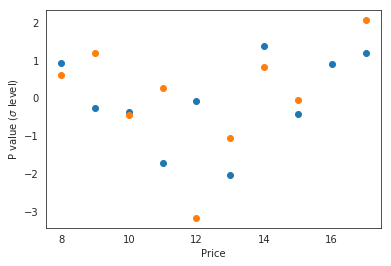

In [336]:
plt.plot(np.unique(fit_infer.data['price'].values),pvalues.T,'o');
plt.xlabel('Price');
plt.ylabel('P value ($\sigma$ level)');

The pvalues look reasonable. There are one or two for the second position that are low (e.g. <-3) but since the rest are reasonable and we are dealing with low number statistics with counts then this is ok.